In [1]:
from mflex.load.read_file import read_issi_rmhd
import numpy as np
from mflex.plot.plot_magnetogram import (
    plot_fieldlines_issi_analytical,
    plot_fieldlines_grid,
    plot_fieldlines_issi_rmhd,
)
from mflex.model.field.bfield_model import magnetic_field
import scipy
import matplotlib.pyplot as plt
from mflex.model.plasma_parameters import (
    deltapres,
    deltaden,
    btemp_linear,
    bpressure_linear,
    bdensity_linear,
    plasma_parameters_linear_test,
)
from mflex.evaluate.metrics import (
    vec_corr_metric,
    cau_Schw_metric,
    norm_vec_err_metric,
    mean_vec_err_metric,
    mag_ener_metric,
    field_div_metric,
    pearson_corr_coeff,
)
from mflex.model.field.utility.height_profile import f_low, f
from mflex.model.field.save import save_field
import matplotlib
from mflex.model.field.utility.seehafer import mirror_magnetogram

--------------------------------------------------
Date: Tue Sep  6 15:18:26 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 10 records of which:
 - 1 are of type NOTICE
 - 1 are of type VERSION
 - 6 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - b2dx [<class 'numpy.ndarray'>]
 - b2dy [<class 'numpy.ndarray'>]
 - b2dz [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------
b'b2d: magnetic vector (Gauss)'
b'Pixel size: 192km*192km'
b'Array example: b2dx(nx,ny)'
xmax, ymax, zmax 98.304 49.152 41.6
xmax_Mm, ymax_Mm, zmax_Mm 98.304 49.152 41.6
nresol_x, nresol_y, nresol_z 512 256 650
pixelsize_x, pixelsize_x_Mm 0.192 0.192
pixelsi

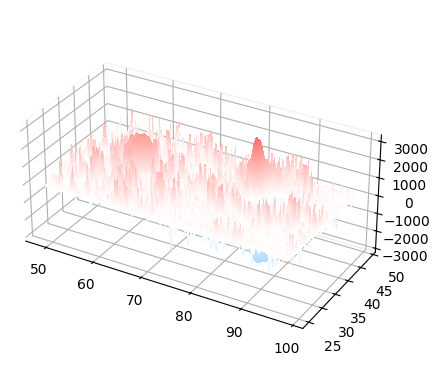

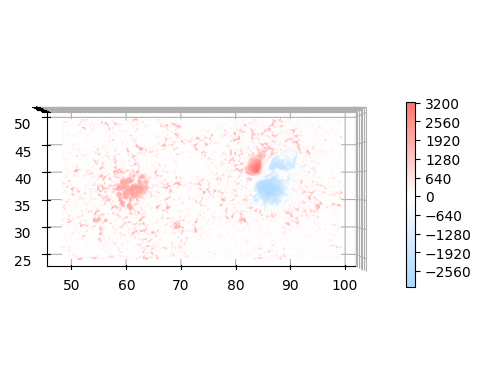

Bz z=0 Maximum 3227.2979
Bz z=0 Minimum -3081.8796


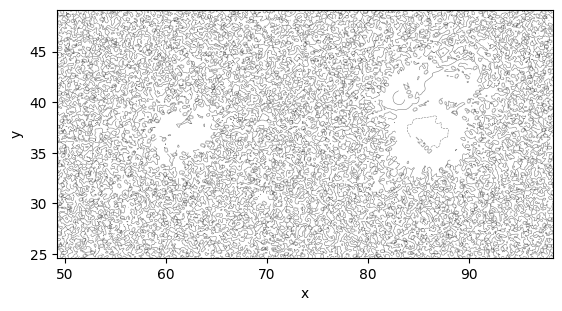

In [9]:
# data = read_issi_analytical("data/Analytic_boundary_data.sav")
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["dimgray", "whitesmoke"]
)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', (
    # Edit this gradient at https://eltos.github.io/gradient/#cmap=A9D6FF-FFFFFF-FF736B
    (0.000, (0.663, 0.839, 1.000)),
    (0.500, (1.000, 1.000, 1.000)),
    (1.000, (1.000, 0.451, 0.420))))

L = 1.0
data = read_issi_rmhd("/Users/lilli/Desktop/mflex/data/RMHD_boundary_data.sav", L)
# BFieldvec_Seehafer = np.load('field_data_potential.npy')

data_bx = data.data_x
data_by = data.data_y
data_bz = data.data_z
nresol_x = data.nresol_x
nresol_y = data.nresol_y
nresol_z = data.nresol_z
pixelsize_x = data.pixelsize_x
pixelsize_y = data.pixelsize_y
pixelsize_z = data.pixelsize_z
nf_max = data.nf_max
xmin = data.xmin
xmax = data.xmax
ymin = data.ymin
ymax = data.ymax
zmin = data.zmin
zmax = data.zmax
z0 = data.z0

deltaz = z0 / 10.0  # z0 at 2Mm so widht of transition region = 200km

x_arr = np.arange(2 * nresol_x) * (xmax - xmin) / (2 * nresol_x - 1) + xmin
y_arr = np.arange(2 * nresol_y) * (ymax - ymin) / (2 * nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.contourf(
    x_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    y_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    data_bz,
    1000,
    # offset=0.0,
    norm=matplotlib.colors.CenteredNorm(),
    cmap=cmap,
)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_box_aspect((xmax, ymax, zmax))
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/ISSI_rmhd_BL1"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
cs = ax.contourf(
    x_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    y_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    data_bz,
    1000,
    # offset=0.0,
    norm=matplotlib.colors.CenteredNorm(),
    cmap=cmap,
)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(90, -90)
ax.set_box_aspect((xmax, ymax, zmax))
ax.set_zticklabels([])
fig.colorbar(cs, shrink=0.5)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/ISSI_rmhd_BL2"
plt.savefig(plotname, dpi=300)
plt.show()

print("Bz z=0 Maximum", data_bz.max())
print("Bz z=0 Minimum", data_bz.min())

fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    y_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    data_bz,
    2,
    colors="k",
    linewidths=0.4,
    alpha=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=5, inline=True)
ax.set_box_aspect(ymax/xmax)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/ISSI_rmhd_BL3"
plt.savefig(plotname, dpi=300)
plt.show()

In [16]:
t_photosphere = 6000.0
t_corona = 10000.0  # 1.0 * 10.0**6
t_z0 = 1.5 * 10**6
t0 = (t_photosphere + t_corona * np.tanh(z0 / deltaz)) / (1.0 + np.tanh(z0 / deltaz))
t1 = (t_corona - t_photosphere) / (1.0 + np.tanh(z0 / deltaz))
t0 = t_z0
t1 = t0 - t_photosphere

g_solar = 272.2  # kg/m^3
kB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
mbar = 1.67262 * 10**-27  # mean molecular weight (proton mass)
h = (
    kB * t0 / (mbar * g_solar) * 10**-6 / L  # h' = h / L
)  # pressure scale height in normalised length scale (10**-6 to convert to Mm, and L**-1 to convert to normalised length scale)
rho0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)
b0 = 3227.2979  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
p0 = t_photosphere * kB * rho0 / mbar  # plasma pressure in kg/(s^2 m)
mu0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)
pB0 = (b0 * 10**-4) ** 2 / (2 * mu0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
beta0 = p0 / pB0  # Plasma Beta, ration plasma to magnetic pressure
h_photo = h / t0 * t_photosphere

temps = np.array((6000.0, 5500.0, 10000.0, 500000.0, 1000000.0, 1500000.0))  # Kelvin
heights = np.array((0.0, 0.5, 2.0, 2.2, 5.0, 100.0))

In [17]:
z0_b = z0
deltaz_b = deltaz
a = 0.0
alpha = 0.0
b = 1.0

bfield = np.load(
    "/Users/lilli/Desktop/mflex/results/issi_rmhd_"
    + str(a)
    + "_"
    + str(alpha)
    + "_"
    + str(b)
    + "_bfield3d.npy"
)
dpartial_bfield = np.load(
    "/Users/lilli/Desktop/mflex/results/issi_rmhd_"
    + str(a)
    + "_"
    + str(alpha)
    + "_"
    + str(b)
    + "_dbzdxdydz3d.npy"
)

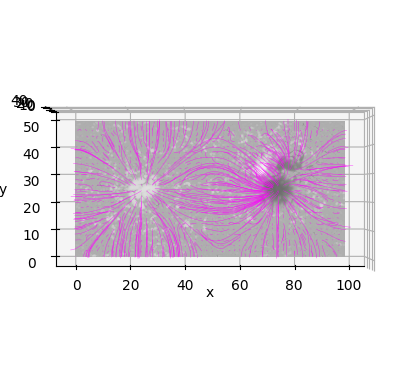

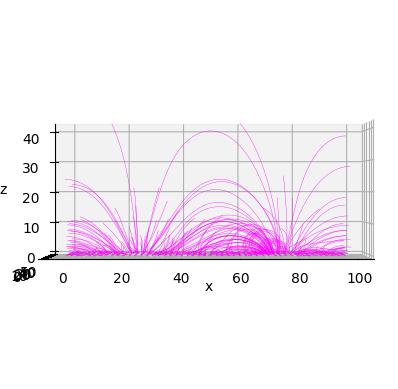

In [28]:
plot_top = plot_fieldlines_grid(
    bfield, L, -xmax, xmax, -ymax, ymax, zmin, zmax, stepsize=2.0, view="top", cmap=cmap
)

plotname = (
    "/Users/lilli/Desktop/Thesis_vonNeu/rmhd_fieldlines_top_"
    + str(a)
    + "_"
    + str(alpha)
    + ".png"
)
plot_top.savefig(plotname, dpi=300)


plot_side = plot_fieldlines_grid(
    bfield,
    L,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    stepsize=2.0,
    view="side",
    cmap=cmap,
)

plotname = (
    "/Users/lilli/Desktop/Thesis_vonNeu/rmhd_fieldlines_side_"
    + str(a)
    + "_"
    + str(alpha)
    + ".png"
)
plot_side.savefig(plotname, dpi=300)

In [29]:
path3d = "/Users/lilli/Desktop/mflex/data/RMHD_3D_data.sav"
data3d = scipy.io.readsav(path3d, python_dict=True, verbose=True)

print(data3d["info_unit"])
print(data3d["info_pixel"])
print(data3d["info_array"])

data_bx_ref = data3d["b3dx"]
data_by_ref = data3d["b3dy"]
data_bz_ref = data3d["b3dz"]

pres_3d = data3d["p3d"] * 10**-1
den_3d = data3d["d3d"] * 10**3

--------------------------------------------------
Date: Tue Sep  6 15:19:40 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type NOTICE
 - 8 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - b3dx [<class 'numpy.ndarray'>]
 - b3dy [<class 'numpy.ndarray'>]
 - b3dz [<class 'numpy.ndarray'>]
 - d3d [<class 'numpy.ndarray'>]
 - p3d [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------
b'b3d, d3d, p3d: magnetic vector (Gauss), plasma density (g/cm^3), plasma pressure (dyn/cm^2)'
b'Pixel spacing: 192km*192km*64km'
b'Array example: d3d(nx,ny,nz)'


In [30]:
print("data_bx_ref.shape", data_bx_ref.shape)
print("data_by_ref.shape", data_by_ref.shape)
print("data_bz_ref.shape", data_bz_ref.shape)
print("pres_3d.shape", pres_3d.shape)
print("den_3d.shape", den_3d.shape)

bfield_bx = bfield[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
bfield_by = bfield[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bfield_bz = bfield[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]
print(bfield_bx.shape)
print(bfield_by.shape)
print(bfield_bz.shape)

issi_bx = 0.0 * bfield_bx
issi_by = 0.0 * bfield_by
issi_bz = 0.0 * bfield_bz

for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, nresol_z):
            issi_bx[i, j, k] = data_bx_ref[k, i, j]
            issi_by[i, j, k] = data_by_ref[k, i, j]
            issi_bz[i, j, k] = data_bz_ref[k, i, j]

"""plot_magnetogram_boundary(data_bz, nresol_x, nresol_y)
plot_magnetogram_boundary(bfield[nresol_y:2*nresol_y, nresol_x:2*nresol_x, 0, 2], nresol_x, nresol_y)
plot_magnetogram_boundary(issi_bz[:, :, 0], nresol_x, nresol_y)"""

x_arr = np.arange(2 * nresol_x) * (xmax - xmin) / (2 * nresol_x - 1) + xmin
y_arr = np.arange(2 * nresol_y) * (ymax - ymin) / (2 * nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

data_bx_ref.shape (652, 256, 512)
data_by_ref.shape (652, 256, 512)
data_bz_ref.shape (652, 256, 512)
pres_3d.shape (652, 256, 512)
den_3d.shape (652, 256, 512)
(256, 512, 650)
(256, 512, 650)
(256, 512, 650)


In [31]:
B_rec = np.array((bfield_by, bfield_bx, bfield_bz))
B_ref = np.array((issi_by, issi_bx, issi_bz))

print("Vec Corr", vec_corr_metric(B_ref, B_rec))
print("Ref", vec_corr_metric(B_ref, B_ref))
print("Cau Schw", cau_Schw_metric(B_ref, B_rec))
print("Ref", cau_Schw_metric(B_ref, B_ref))
print("Norm err", norm_vec_err_metric(B_ref, B_rec))
print("Ref", norm_vec_err_metric(B_ref, B_ref))
print("Mean err", mean_vec_err_metric(B_ref, B_rec))
print("Ref", mean_vec_err_metric(B_ref, B_ref))
print("Mag ener", mag_ener_metric(B_ref, B_rec))
print("Ref", mag_ener_metric(B_ref, B_ref))

Vec Corr 0.8751793534229577
Ref 1.0
Cau Schw 0.6957946542593149
Ref 1.0
Norm err 0.4907635681074296
Ref 0.0
Mean err 6.072345386307729
Ref 0.0
Mag ener 2.2370806804596484
Ref 1.0


In [22]:
# backpres = np.zeros_like(z_arr)
# backden = np.zeros_like(z_arr)

# dpres = np.zeros((nresol_y, nresol_x, nresol_z))
# dden = np.zeros((nresol_y, nresol_x, nresol_z))

# fpres_lin = np.zeros((nresol_y, nresol_x, nresol_z))
# fden_lin = np.zeros((nresol_y, nresol_x, nresol_z))

# for ix in range(nresol_x):
#     for iy in range(nresol_y):
#         for iz, z in enumerate(z_arr):
#             bz = bfield[nresol_y + iy, nresol_x + ix, iz, 2]
#             bdotgradbz = (
#                 bfield[nresol_y + iy, nresol_x + ix, iz, 2]
#                 * dpartial_bfield[nresol_y + iy, nresol_x + ix, iz, 2]
#                 + bfield[nresol_y + iy, nresol_x + ix, iz, 1]
#                 * dpartial_bfield[nresol_y + iy, nresol_x + ix, iz, 1]
#                 + bfield[nresol_y + iy, nresol_x + ix, iz, 0]
#                 * dpartial_bfield[nresol_y + iy, nresol_x + ix, iz, 0]
#             )

#             backpres[iz] = bpressure_linear(z, temps, heights, t0, h)
#             backden[iz] = bdensity_linear(z, temps, heights, t0, h, t_photosphere)

#             dpres[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a, b, bz)
#             dden[iy, ix, iz] = deltaden(z, z0_b, deltaz_b, a, b, bz, bdotgradbz)

#             fpres_lin[iy, ix, iz] = (
#                 b0**2.0 / mu0 * 0.5 * beta0 * backpres[iz] * 10**-8
#                 + dpres[iy, ix, iz] / mu0 * 10**-8
#             )
#             fden_lin[iy, ix, iz] = (
#                 0.5
#                 * beta0
#                 / h
#                 * t0
#                 / t_photosphere
#                 * b0**2.0
#                 / (mu0 * g_solar * L)
#                 * backden[iz]
#                 * 10**-14
#                 + dden[iy, ix, iz] / (mu0 * g_solar * L) * 10**-14
#             )

In [32]:
t_photosphere = 6000.0
t_corona = 10000.0  # 1.0 * 10.0**6
t_z0 = 1.5 * 10**6
t0 = (t_photosphere + t_corona * np.tanh(z0 / deltaz)) / (1.0 + np.tanh(z0 / deltaz))
t1 = (t_corona - t_photosphere) / (1.0 + np.tanh(z0 / deltaz))
t0 = t_z0
t1 = t0 - t_photosphere

g_solar = 272.2  # kg/m^3
kB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
mbar = 1.67262 * 10**-27  # mean molecular weight (proton mass)
h = (
    kB * t0 / (mbar * g_solar) * 10**-6 / L  # h' = h / L
)  # pressure scale height in normalised length scale (10**-6 to convert to Mm, and L**-1 to convert to normalised length scale)
rho0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)
b0 = 3227.2979  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
p0 = t_photosphere * kB * rho0 / mbar  # plasma pressure in kg/(s^2 m)
mu0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)
pB0 = (b0 * 10**-4) ** 2 / (2 * mu0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
beta0 = p0 / pB0  # Plasma Beta, ration plasma to magnetic pressure
h_photo = h / t0 * t_photosphere

temps = np.array((6000.0, 5500.0, 10000.0, 500000.0, 1000000.0, 1500000.0))  # Kelvin
heights = np.array((0.0, 0.5, 2.0, 2.2, 5.0, 100.0))

In [33]:
(
    backpres,
    backden,
    dpres,
    dden,
    fpres_lin,
    fden_lin,
    backtemp,
) = plasma_parameters_linear_test(
    z_arr,
    temps,
    heights,
    t0,
    t_photosphere,
    h,
    bfield,
    dpartial_bfield,
    z0_b,
    deltaz_b,
    a,
    b,
    mu0,
    g_solar,
    b0,
    beta0,
    L,
)

In [34]:
print("Pressure minimum lin", fpres_lin.min())
print("Pressure minimum lin", np.unravel_index(fpres_lin.argmin(), fpres_lin.shape))
print("Density minimum lin", fden_lin.min())
print("Density minimum lin", np.unravel_index(fden_lin.argmin(), fpres_lin.shape))

print("Pressure minimum issi", pres_3d.min())
print("Pressure minimum issi", np.unravel_index(pres_3d.argmin(), pres_3d.shape))
print("Density minimum issi", den_3d.min())
print("Density minimum issi", np.unravel_index(den_3d.argmin(), pres_3d.shape))

Pressure minimum lin 0.2939710890550779
Pressure minimum lin (0, 0, 649)
Density minimum lin 2.98615481399007e-11
Density minimum lin (0, 0, 649)
Pressure minimum issi 0.0011467607
Pressure minimum issi (63, 177, 233)
Density minimum issi 1.944082e-16
Density minimum issi (57, 92, 440)


In [35]:
print("Pressure maximum lin", fpres_lin.max())
print("Pressure maximum lin", np.unravel_index(fpres_lin.argmax(), fpres_lin.shape))
print("Density maximum lin", fden_lin.max())
print("Density maximum lin", np.unravel_index(fden_lin.argmax(), fpres_lin.shape))

print("Pressure maximum issi", pres_3d.max())
print("Pressure maximum issi", np.unravel_index(pres_3d.argmax(), pres_3d.shape))
print("Density maximum issi", den_3d.max())
print("Density maximum issi", np.unravel_index(den_3d.argmax(), pres_3d.shape))

Pressure maximum lin 13372.142985256663
Pressure maximum lin (0, 0, 0)
Density maximum lin 0.00027000000000000006
Density maximum lin (0, 0, 0)
Pressure maximum issi 181849.36
Pressure maximum issi (0, 4, 147)
Density maximum issi 4.4585659e-07
Density maximum issi (0, 90, 165)


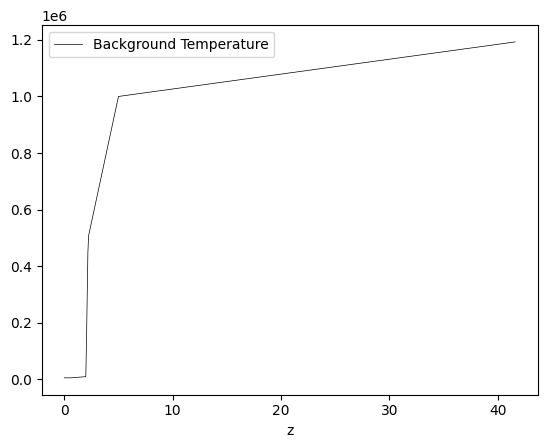

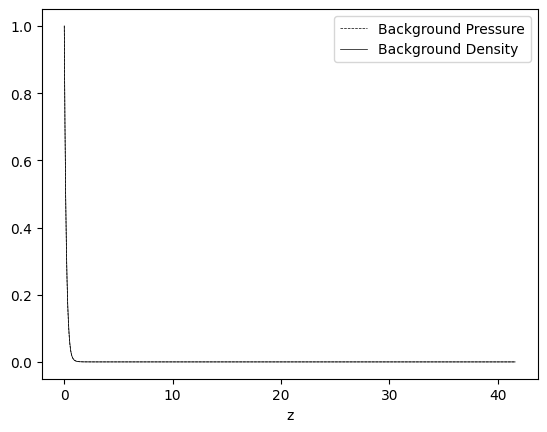

In [27]:
plt.plot(
    z_arr,
    backtemp,
    linewidth=0.5,
    color="black",
    linestyle="solid",
    label="Background Temperature",
)
plt.legend()
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/ISSI_rmhd_btemp.png"
plt.savefig(plotname, dpi=300)
plt.show()

plt.plot(
    z_arr,
    backpres,
    linewidth=0.5,
    color="black",
    linestyle="dashed",
    label="Background Pressure",
)
plt.plot(
    z_arr,
    backden,
    linewidth=0.5,
    color="black",
    linestyle="solid",
    label="Background Density",
)
plt.legend()
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/ISSI_rmhd_batm.png"
plt.savefig(plotname, dpi=300)
plt.show()

(650,)
(652, 256, 512)
(256, 512, 650)


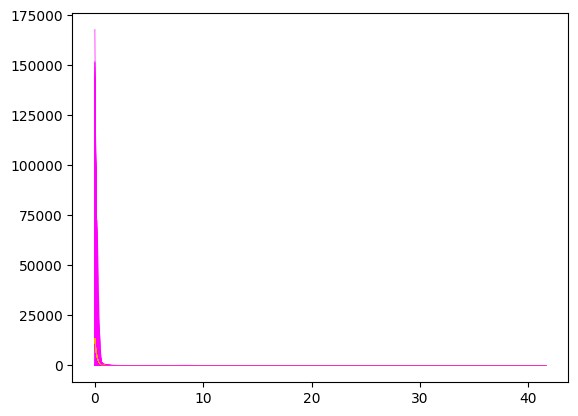

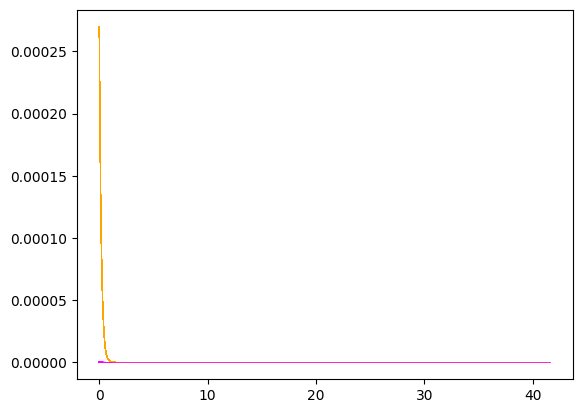

In [36]:
b_back = np.zeros((2 * nresol_y, 2 * nresol_x))
b_back = bfield[:, :, 0, 2]

b_back_small = b_back[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x]
maxcoord = np.unravel_index(
    np.argmax(b_back_small, axis=None),
    b_back_small.shape,
)
iy = int(maxcoord[0])
ix = int(maxcoord[1])

"""plt.plot(z_arr, abs(dden), linewidth=0.5, color="black", linestyle="solid")
plt.plot(z_arr, abs(dpres), linewidth=0.5, color="blue", linestyle="solid")
# plt.axvline(x=z0, color="black", linestyle="solid", linewidth=0.25)
# plt.legend()
plt.xlabel("z")
plt.yscale("log")
# plt.ylim([10**-20, 0.0])
# plt.xlim([0.4, 0.6])
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure9b.png"
# plt.savefig(plotname, dpi=300)
plt.show()"""

print(z_arr.shape)
print(pres_3d.shape)
print(fpres_lin.shape)

# plt.plot(z_arr, fpres_lin, linewidth=0.5, color="blue")

for ix in range(0, nresol_x, 10):
    for iy in range(0, nresol_y, 10):
        plt.plot(
            z_arr,
            fpres_lin[iy, ix, :],
            linewidth=0.5,
            color="orange",
            label="Rec pressure",
        )
        plt.plot(
            z_arr,
            pres_3d[0:650, iy, ix],
            linewidth=0.5,
            color="magenta",
            label="Ref pressure",
        )
# plt.legend()
# plotname = "/Users/lilli/Desktop/mflex/seminar2024/ISSI_rmhd_fp_maxB"
# plt.savefig(plotname, dpi=300)
plt.show()

# plt.plot(z_arr, fden_lin, linewidth=0.5, color="blue")
for ix in range(0, nresol_x, 10):
    for iy in range(0, nresol_y, 10):
        plt.plot(
            z_arr,
            fden_lin[iy, ix, :],
            linewidth=0.5,
            color="orange",
            label="Rec density",
        )
        plt.plot(
            z_arr,
            den_3d[0:650, iy, ix],
            linewidth=0.5,
            color="magenta",
            label="Ref density",
        )
# plt.legend()
# plotname = "/Users/lilli/Desktop/mflex/seminar2024/ISSI_rmhd_fd_maxB"
# plt.savefig(plotname, dpi=300)
plt.show()

In [36]:
B_ref_See = 0.0 * bfield
print(B_ref_See.shape)
print(B_ref.shape)
h1 = 0.01  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

B_ref_transpose = B_ref.transpose((1, 2, 3, 0))

print(B_ref_transpose.shape)
for iz in range(0, nresol_z):
    for ix in range(0, nresol_x):
        for iy in range(0, nresol_y):
            for id in range(0, 3):
                B_ref_See[nresol_y + iy, nresol_x + ix, iz, id] = B_ref[id, iy, ix, iz]
                B_ref_See[nresol_y + iy, ix, iz, id] = -B_ref[
                    id, iy, nresol_x - 1 - ix, iz
                ]
                B_ref_See[iy, nresol_x + ix, iz, id] = -B_ref[
                    id, nresol_y - 1 - iy, ix, iz
                ]
                B_ref_See[iy, ix, iz, id] = B_ref[
                    id, nresol_y - 1 - iy, nresol_x - 1 - ix, iz
                ]

print(
    "Field line",
    field_div_metric(
        B_ref_See,
        bfield,
        h1,
        hmin,
        hmax,
        eps,
        nresol_x,
        nresol_y,
        nresol_z,
        -xmax,
        xmax,
        -ymax,
        ymax,
        zmin,
        zmax,
        stepsize=0.1,
    ),
)
print(
    "Ref",
    field_div_metric(
        B_ref_See,
        B_ref_See,
        h1,
        hmin,
        hmax,
        eps,
        nresol_x,
        nresol_y,
        nresol_z,
        -xmax,
        xmax,
        -ymax,
        ymax,
        zmin,
        zmax,
        stepsize=0.1,
    ),
)

plot_top = plot_fieldlines_issi_rmhd(
    B_ref_transpose,
    L,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    stepsize=2.0,
    view="top",
    cmap=cmap,
)


plotname = (
    "/Users/lilli/Desktop/Thesis_vonNeu/rmhd_fieldlines_top_ref_"
    + str(a)
    + "_"
    + str(alpha)
    + ".png"
)
plot_top.savefig(plotname, dpi=300)


plot_side = plot_fieldlines_issi_rmhd(
    B_ref_transpose,
    L,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    stepsize=2.0,
    view="side",
    cmap=cmap,
)


plotname = (
    "/Users/lilli/Desktop/Thesis_vonNeu/rmhd_fieldlines_side_ref_"
    + str(a)
    + "_"
    + str(alpha)
    + ".png"
)
plot_side.savefig(plotname, dpi=300)

(512, 1024, 650, 3)
(3, 256, 512, 650)
(256, 512, 650, 3)


/Users/lilli/Desktop/mflex/mflex/evaluate/metrics.py:268: RuntimeWarning: invalid value encountered in scalar divide
  (fieldline_rec[len_rec - 1, 1] - fieldline_ref[len_ref - 1, 1])
/Users/lilli/Desktop/mflex/mflex/evaluate/metrics.py:268: RuntimeWarning: divide by zero encountered in scalar divide
  (fieldline_rec[len_rec - 1, 1] - fieldline_ref[len_ref - 1, 1])


Pressure minimum lin -372.404450733336
Pressure minimum lin 42846066
Density minimum lin -2.5951536480510165e-06
Density minimum lin 42847381
Pressure minimum lin ref 0.0011467607
Pressure minimum lin ref 8348393
Density minimum lin ref 1.944082e-16
Density minimum lin ref 7518648


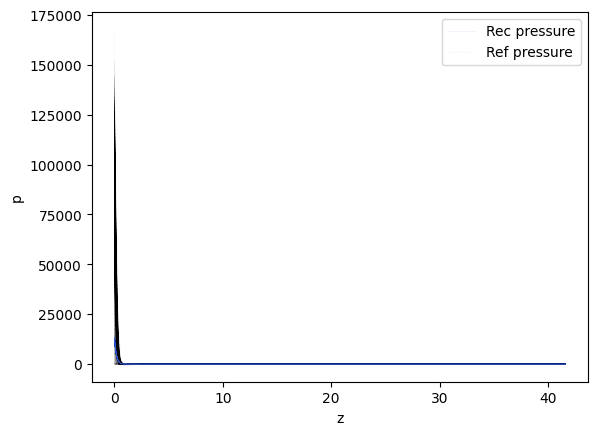

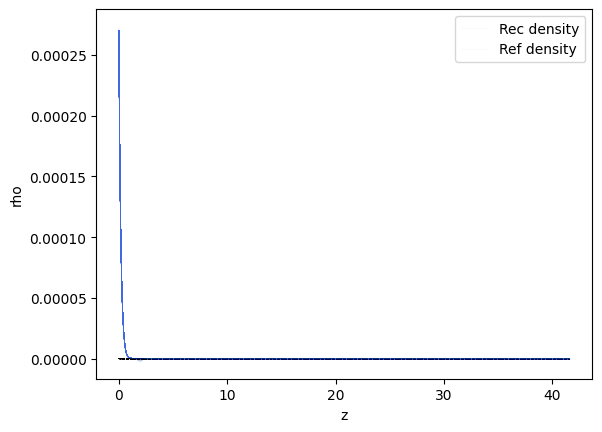

In [ ]:
print("Pressure minimum lin", fpres_lin.min())
print("Pressure minimum lin", fpres_lin.argmin())
print("Density minimum lin", fden_lin.min())
print("Density minimum lin", fden_lin.argmin())

print("Pressure minimum lin ref", pres_3d.min())
print("Pressure minimum lin ref", pres_3d.argmin())
print("Density minimum lin ref", den_3d.min())
print("Density minimum lin ref", den_3d.argmin())

plt.plot(
    z_arr,
    fpres_lin[0, 0, :],
    linewidth=0.5,
    color="royalblue",
    alpha=0.1,
    label="Rec pressure",
)
plt.plot(
    z_arr,
    pres_3d[0:650, 0, 0],
    linewidth=0.5,
    color="black",
    linestyle="dashed",
    alpha=0.04,
    label="Ref pressure",
)
for ix in range(0, nresol_x, 10):
    for iy in range(0, nresol_y, 10):
        plt.plot(
            z_arr, fpres_lin[iy, ix, :], linewidth=0.5, color="royalblue", alpha=0.1
        )
        plt.plot(
            z_arr,
            pres_3d[0:650, iy, ix],
            linewidth=0.5,
            color="black",
            linestyle="dashed",
            alpha=0.04,
        )
plt.ylabel("p")
plt.xlabel("z")
plt.legend()
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/ISSI_rmhd_fp_xy.png"
plt.savefig(plotname, dpi=300)
plt.show()

plt.plot(
    z_arr,
    fden_lin[0, 0, :],
    linewidth=0.5,
    color="royalblue",
    alpha=0.04,
    label="Rec density",
)
plt.plot(
    z_arr,
    den_3d[0:650, 0, 0],
    linewidth=0.5,
    color="black",
    linestyle="dashed",
    alpha=0.04,
    label="Ref density",
)
for ix in range(0, nresol_x, 10):
    for iy in range(0, nresol_y, 10):
        plt.plot(
            z_arr, fden_lin[iy, ix, :], linewidth=0.5, color="royalblue", alpha=0.04
        )
        plt.plot(
            z_arr,
            den_3d[0:650, iy, ix],
            linewidth=0.5,
            color="black",
            linestyle="dashed",
            alpha=0.04,
        )
plt.ylabel("rho")
plt.xlabel("z")
plt.legend()
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/ISSI_rmhd_fd_xy.png"
plt.savefig(plotname, dpi=300)
plt.show()

Pearson Correlation reference value for pressure PearsonRResult(statistic=1.0, pvalue=0.0)
Pearson Correlation reference value for density PearsonRResult(statistic=1.0, pvalue=0.0)
Pearson Correlation actual value for pressure PearsonRResult(statistic=0.4957933754660062, pvalue=0.0)
Pearson Correlation actual value for density PearsonRResult(statistic=0.7182045663785473, pvalue=0.0)


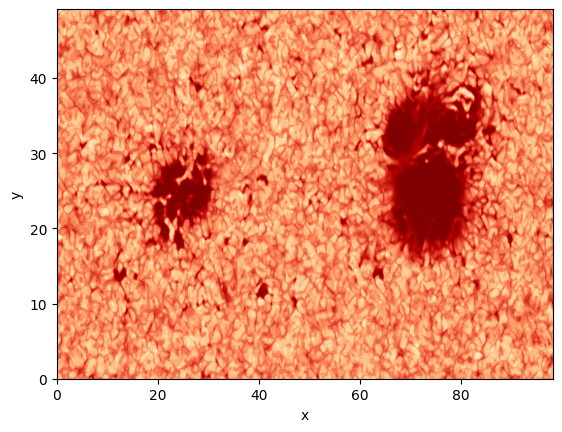

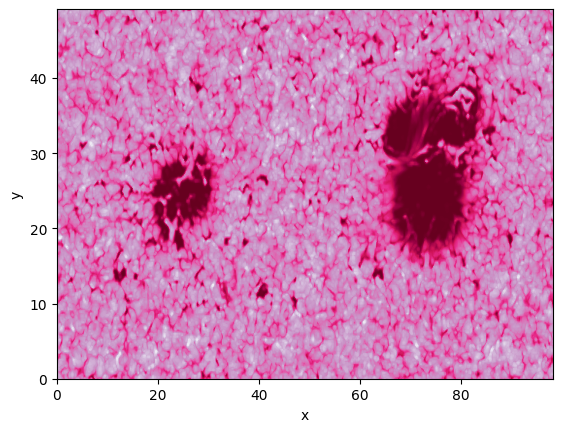

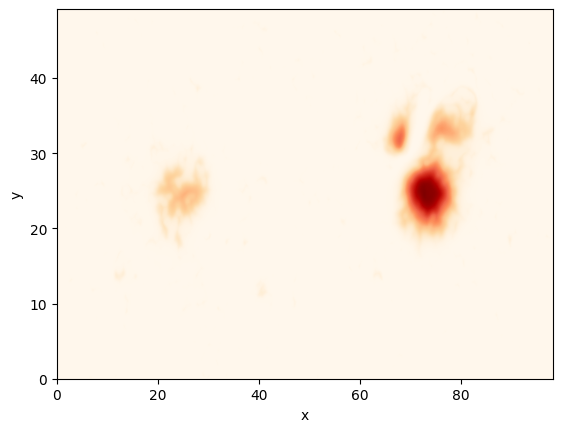

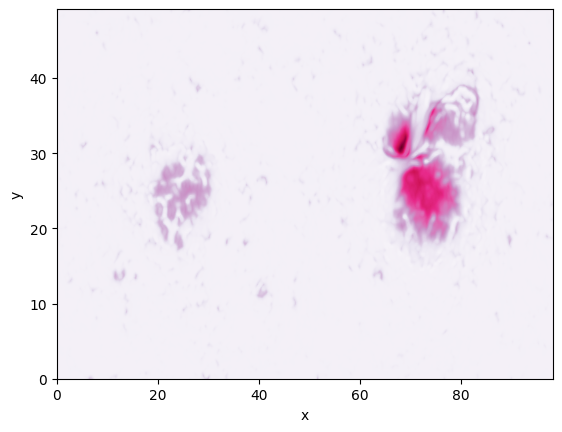

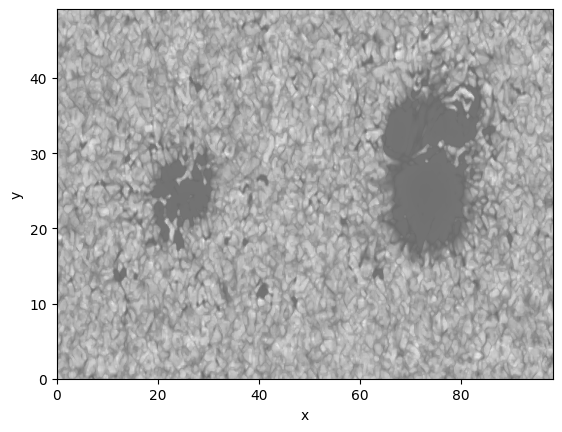

Locator attempting to generate 1002 ticks ([4.5692e-05, ..., 4.9696e-05]), which exceeds Locator.MAXTICKS (1000).


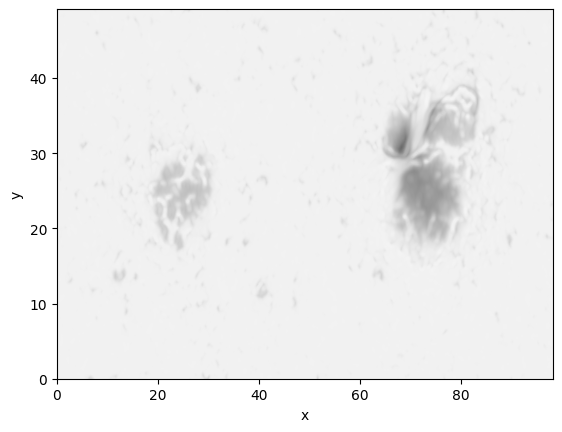

Max diff p 28191.676082881084
Max diff d 4.969212522276557e-05


In [ ]:
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin

x_plot = np.outer(y_arr, np.ones(nresol_x))
y_plot = np.outer(x_arr, np.ones(nresol_y)).T

pres_3d = pres_3d[0:650, :, :]
den_3d = den_3d[0:650, :, :]

pres_surface_ref, den_surface_ref, pres_surface_rec, den_surface_rec = (
    pearson_corr_coeff(
        pres_3d,
        den_3d,
        fpres_lin,
        fden_lin,
        nresol_x,
        nresol_y,
        nresol_z,
        zmin,
        zmax,
    )
)

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, pres_surface_ref, 1000, cmap="OrRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect((xmax, ymax, zmax))
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/ISSI_rmhd_fp_ref_los.png"
fig.colorbar(cs, shrink=0.5)
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, den_surface_ref, 1000, cmap="PuRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect((xmax, ymax, zmax))
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/ISSI_rmhd_fd_ref_los.png"
fig.colorbar(cs, shrink=0.5)
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, pres_surface_rec, 1000, cmap="OrRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect((xmax, ymax, zmax))
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/ISSI_rmhd_fp_rec_los.png"
fig.colorbar(cs, shrink=0.5)
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, den_surface_rec, 1000, cmap="PuRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect((xmax, ymax, zmax))
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/ISSI_rmhd_fd_rec_los.png"
fig.colorbar(cs, shrink=0.5)
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, abs(pres_surface_rec - pres_surface_ref), 1000, cmap=cmap)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect((xmax, ymax, zmax))
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/ISSI_analytical_fp_los_error.png"
fig.colorbar(cs, shrink=0.5)
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, abs(den_surface_rec - den_surface_ref), 1000, cmap=cmap)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect((xmax, ymax, zmax))
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/ISSI_rmhd_fd_los_error.png"
fig.colorbar(cs, shrink=0.5)
plt.savefig(plotname, dpi=300)
plt.show()

error_d = abs(den_surface_rec - den_surface_ref) 
error_p = abs(pres_surface_rec - pres_surface_ref) 
print("Max diff p", error_p.max())
print("Max diff d", error_d.max())